In [1]:
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from GroupingAlgorithm import *
from utils import *
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.drivers import PyQuanteDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.opflow.primitive_ops import Z2Symmetries
from qiskit.opflow import converters
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_paris')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris)
NUM_SHOTS = 2**13  # Number of shots for each circuit

In [3]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PyQuanteDriver(molecule)
qmolecule = driver.run()
freezeCoreTransfomer = FreezeCoreTransformer( freeze_core=True, remove_orbitals= [3,4] )
problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'
mapper = ParityMapper()

converter = QubitConverter( mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1],) #1] 

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha, problem.molecule_data_transformed.num_beta)

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

qubit_op = converter.convert(main_op, num_particles=num_particles)

num_qubits = qubit_op.num_qubits
WC = list(range(num_qubits))
WC = list(permutations(list(range(num_qubits)),2))

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

print( num_qubits )
print( qubit_op )

4
-0.20316612481217325 * IIII
+ (-0.365258527098598-1.3877787807814457e-17j) * ZIII
+ 0.09275974420404098 * IZII
- 0.2118902053549851 * ZZII
+ (0.365258527098598+2.7755575615628914e-17j) * IIZI
- 0.11384420116816225 * ZIZI
+ 0.11395335131674317 * IZZI
+ (-0.06043919280467715-3.469446951953614e-18j) * ZZZI
+ (-0.09275974420404105-3.469446951953614e-18j) * IIIZ
+ 0.11395335131674318 * ZIIZ
+ (-0.12274347556009738-6.938893903907228e-18j) * IZIZ
+ 0.056287757667526306 * ZZIZ
+ (-0.2118902053549851-6.938893903907228e-18j) * IIZZ
+ 0.06043919280467715 * ZIZZ
- 0.056287757667526306 * IZZZ
+ 0.0846016988633049 * ZZZZ
+ 0.019390023793252498 * XIII
+ (-0.019390023793252498+8.673617379884035e-19j) * XZII
- 0.010951534973539137 * XIZI
+ 0.010951534973539137 * XZZI
+ 0.01277809801936714 * XIIZ
- 0.01277809801936714 * XZIZ
- 0.00900252139905185 * XIZZ
+ 0.00900252139905185 * XZZZ
- 0.002936887226605865 * IXII
- 0.0029368872266058656 * ZXII
+ 0.010679892682752462 * IXZI
+ 0.010679892682752462 * ZXZI


In [4]:
# num_qubits = 2
# qubit_op = RandomHamiltonian( num_qubits, 6 )
# WC = list(range(num_qubits))
# WC = list(permutations(list(range(num_qubits)),2))
# init_state = QuantumCircuit(num_qubits)
# print( qubit_op )

In [5]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
result_exact.eigenvalue 

(-1.0887061050307454-8.101384526250279e-17j)

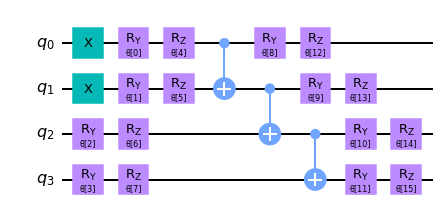

In [6]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

In [7]:
def callback( evals, params ):  
    display("{}, {}".format(len(evaluations),evals))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []

In [8]:
optimizer = SPSA( maxiter=100, last_avg=1 )

In [9]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

In [10]:
result_exact.eigenvalue 

(-1.0887061050307454-8.101384526250279e-17j)

In [11]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-1.0684914358693567


In [12]:
solver = VQE( ansatz, optimizer, pars, grouping = 'TPB' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-0.9599930473793601


In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_paris )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-0.9883603373608068


In [14]:
parameters  = []
evaluations = []
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-1.0647613900772392


In [15]:
# parameters  = []
# evaluations = []
# optimizer   = SPSA( maxiter=50, last_avg=1 )
# solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=backend_noise )
# results = solver.compute_minimum_eigenvalue(qubit_op)
# print( results.eigenvalue )

In [16]:
# plt.plot( evaluations )

In [17]:
qi = QuantumInstance( backend_sim, shots = NUM_SHOTS )
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=50, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', quantum_instance=qi )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-0.8658226297324528


In [18]:
solver.ansatz

In [19]:
solver.cleanup_parameterized_circuits

<bound method VariationalAlgorithm.cleanup_parameterized_circuits of <VQE.VQE object at 0x00000162C8D53C88>>

In [20]:
solver.construct_expectation

<bound method VQE.construct_expectation of <VQE.VQE object at 0x00000162C8D53C88>>

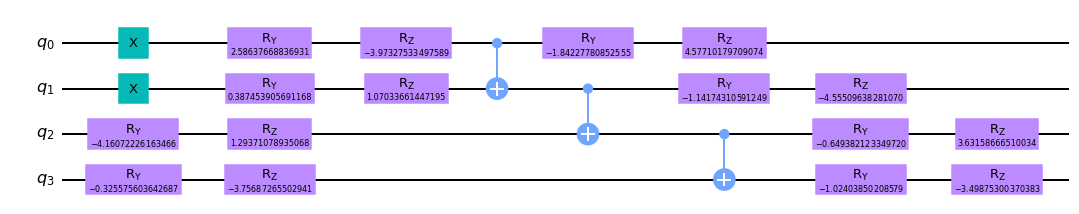

In [21]:
solver.get_optimal_circuit().draw(output='mpl')

In [22]:
solver.get_optimal_cost()

-0.8658226297324528

In [23]:
solver.get_optimal_vector()

{'0010': 0.3914054703086047,
 '1010': 0.18520733736140152,
 '0001': 0.3694247005480278,
 '1001': 0.17917726470593304,
 '0110': 0.17780947932407878,
 '1111': 0.3605618987254477,
 '0011': 0.4803258171543562,
 '1100': 0.17258376589355096,
 '0000': 0.2593467605109036,
 '0101': 0.17044862679118303,
 '0111': 0.232544938533394,
 '0100': 0.10539638721275033,
 '1110': 0.15388840315306412,
 '1011': 0.17080633678965193,
 '1000': 0.08267972847076846,
 '1101': 0.024705294220065465}

In [24]:
# solver.get_prob_vector_for_params()

In [25]:
# solver.get_probabilities_for_counts()

In [26]:
solver.initial_point

[0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01]

In [27]:
solver.optimal_params

array([ 2.58637669, -0.64938212, -1.0240385 ,  4.5771018 , -4.55509638,
        3.63158667, -3.498753  ,  0.38745391, -4.16072226, -0.3255756 ,
       -3.97327533,  1.07033661,  1.29371079, -3.75687266, -1.84227781,
       -1.14174311])

In [28]:
solver.optimizer

In [29]:
solver.quantum_instance

In [30]:
solver.supports_aux_operators()

False

In [31]:
print( solver.print_settings() )


==================== Setting of VQE ============================
Algorithm: VQE
-- ansatz_params: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9])]
-- ansatz:         ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├─────────